# Night Light Project

### Objectives:
1. Jabodetabek Coordinate Mapping
2. Date filtering function
3. Vector to Raster Conversion
4. Raster to Numeric Conversion

## Notes

1. To summarize your raster data, use aggregation (mean/media/min/max/sum) or reducer information to zonal statistic
2. Cautious in the use of SOL to compare regions, since scale of reducer can affect the aggregation.
3. To detect changes, you can measure per pixel rate of change (slope of change). This measures the radiance over time

## Question
1. How to determine min/max for slope of change

### Import Libraries

In [1]:
import geemap
import ee

In [2]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Initialize Map and VIIRS Band

In [4]:
#Map Params for jakarta

lat = -6.2
lon = 106.8166
buffer = 200000
zoomlevel = 7

#Mean/median is a handy way to replace reducer method
viirs2019_12 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").filterDate("2019-01-01", "2019-12-31").select('avg_rad').median()
#get how many images
# print(viirs2019_12.size().getInfo())     

In [5]:
#if you want to clip on multiple date, here is what you need.
clip_func = lambda x: x.clip(aoi_CA)

#to clip image
#circle
aoi = ee.Geometry.Point([lon, lat]).buffer(buffer)
#follow a regional shape
aoi_CA = ee.FeatureCollection('TIGER/2016/States').filter(ee.Filter.eq('NAME', 'Jakarta q'))
viirs_clipped = viirs2019_12.clip(aoi)

map = geemap.Map(center=[lat, lon], zoom=zoomlevel)
map.add_basemap('SATELLITE')
map.addLayer(viirs2019_12, {}, "VIIRS-DNB Dec 2019")
map.addLayerControl()
map

Map(center=[-6.2, 106.8166], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [6]:
#masking light only
map_mask = geemap.Map(center=[lat, lon], zoom=zoomlevel)
map_mask.add_basemap('SATELLITE')
map_mask.addLayer(viirs2019_12.mask(viirs2019_12), {}, "VIIRS-DNB Dec 2019")
map_mask.addLayerControl()
map_mask

Map(center=[-6.2, 106.8166], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

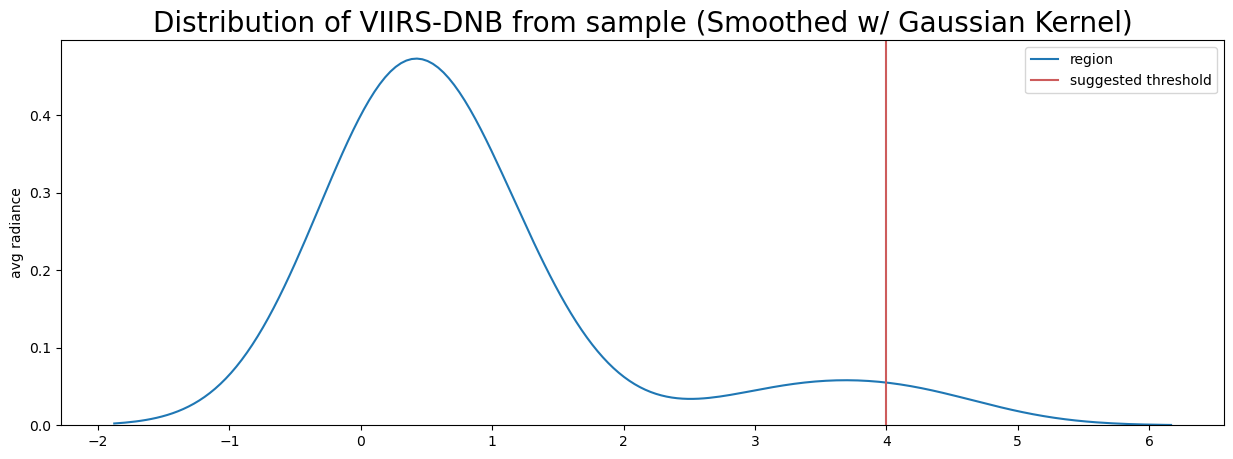

In [7]:
#histogram

arr = geemap.ee_to_numpy(viirs2019_12, region=aoi)

fig, ax = plt.subplots(figsize=(15, 5))
sns.kdeplot(arr.flatten(), label='region', legend=True, ax=ax)
ax.axvline(4, color='indianred', label='suggested threshold')
plt.legend(fontsize=20)
plt.title("Distribution of VIIRS-DNB from sample (Smoothed w/ Gaussian Kernel)", fontsize=20)
plt.ylabel('avg radiance')
plt.legend()

In [8]:
#Filter above 4 

viirs2019_gte = viirs2019_12.gte(4)

map_gte = geemap.Map(center=[lat, lon], zoom=zoomlevel)
map_gte.add_basemap('SATELLITE')
map_gte.addLayer(viirs2019_gte.mask(viirs2019_gte), {}, "Avg rad => 4")
map_gte.addLayerControl()
map_gte

Map(center=[-6.2, 106.8166], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [9]:
#map zones based on chained boolean

zones = viirs2019_12.gt(1.5).add(viirs2019_12.gt(2)).add(viirs2019_12.gt(5))

map_zones = geemap.Map(center=[lat, lon], zoom=zoomlevel)
map_zones.add_basemap('SATELLITE')
map_zones.addLayer(zones.mask(zones), {'palette':['#cc0909','#e67525','#fff825']}, 'zones')
map_zones.addLayerControl()
map_zones

Map(center=[-6.2, 106.8166], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [10]:
#compare annual compositve different year

start = 2015
end = 2019

years = ee.List.sequence(start, end)
print(f"This list has {years.size().getInfo()} years in it")

This list has 5 years in it


In [11]:
#function to get image collection of all years in list
def viirs_annual_median_reduce(year) :
    return ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filter(ee.Filter.calendarRange(year,  year, "year")).select('avg_rad').median().set("year", year)

#Convert list to collection of image composition each year
yearComps = ee.ImageCollection.fromImages(years.map(viirs_annual_median_reduce))

## Reduce image noise and composition

In [12]:
#Extracting taman anggrek mall data

anggrek_lon = 106.793106
anggrek_lat = -6.178843

poi_anggrek = ee.Geometry.Point(anggrek_lon, anggrek_lat).buffer(500)
viirs_anggrek = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2019-01-01', '2019-12-31')
anggrek_clip = viirs_anggrek.select('avg_rad').first().clip(poi_anggrek)

In [13]:
mu = anggrek_clip.reduceRegion(reducer = ee.Reducer.mean(), scale=30)
std = anggrek_clip.reduceRegion(reducer = ee.Reducer.stdDev(), scale=30)

mu = ee.Number(mu.get('avg_rad'))
std = ee.Number(std.get('avg_rad'))

print(f"variance is {mu.getInfo():.4f}, whereas standard deviation is {std.getInfo():.4f}")

variance is 57.1348, whereas standard deviation is 5.5934


In [14]:
#clean layer
anggrek_clean = anggrek_clip.subtract(mu).divide(std)

left_layer = geemap.ee_tile_layer(anggrek_clip, {}, 'VIIRS-DNB 2019', opacity=0.75)
right_layer = geemap.ee_tile_layer(anggrek_clean, {}, 'VIIRS-DNB 2019 (Zero-centered and unit variance)', opacity=0.75)

map_anggrek_compare = geemap.Map()
map_anggrek_compare.centerObject(poi_anggrek, zoom=8)
map_anggrek_compare.add_basemap('SATELLITE')
map_anggrek_compare.split_map(left_layer = left_layer, right_layer = right_layer)
map_anggrek_compare.addLayerControl()
map_anggrek_compare

Map(center=[-6.178842487075305, 106.79310601429245], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [15]:
#Image composition 5 years

map_composite = geemap.Map(center=[lat, lon], zoom=zoomlevel)
map_composite.add_basemap('SATELLITE')

for year in range(start, end+1):
    img = yearComps.filterMetadata("year", "equals", year).first()
    map_composite.addLayer(img.mask(img), {}, f"VIIRS-DNB {year}", opacity=.75)
    
map_composite.addLayerControl()
map_composite

Map(center=[-6.2, 106.8166], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [16]:
#Compare image 

left_layer = geemap.ee_tile_layer(yearComps.filterMetadata("year", "equals", 2015), {}, 'VIIRS-DNB 2015', opacity = 0.75)
right_layer = geemap.ee_tile_layer(yearComps.filterMetadata("year", "equals", 2019), {}, 'VIIRS-DNB 2019', opacity =0.75)

map_split = geemap.Map(center=[lat, lon], zoom=zoomlevel)
map_split.add_basemap('SATELLITE')
map_split.split_map(left_layer = left_layer, right_layer = right_layer)
map_split.addLayerControl()
map_split

Map(center=[-6.2, 106.8166], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

## Extract time series data to pandas dataframe

In [17]:
#increase time span
viirs_anggrek = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2019-06-01', '2022-06-01')


#function to get a mean in the region in scale of 30
def poi_mean(img):
    mean = img.reduceRegion(reducer = ee.Reducer.mean(), geometry=poi_anggrek, scale=30).get('avg_rad')
    return img.set('date', img.date().format()).set('mean', mean)

In [18]:
poi_reduced = viirs_anggrek.map(poi_mean)

#convert image collection to list
nested_list = poi_reduced.reduceColumns(ee.Reducer.toList(2), ['date', 'mean']).values().get(0)
#list to dataframe
anggrek_df = pd.DataFrame(nested_list.getInfo(), columns=['date', 'mean'])
anggrek_df.tail(20)

,date,mean
16,2020-10-01T00:00:00,39.980071
17,2020-11-01T00:00:00,48.501265
18,2020-12-01T00:00:00,0.000000
19,2021-01-01T00:00:00,0.000000
20,2021-02-01T00:00:00,33.030148
21,2021-03-01T00:00:00,47.969539
22,2021-04-01T00:00:00,46.909697
23,2021-05-01T00:00:00,40.666102
24,2021-06-01T00:00:00,46.486048
25,2021-07-01T00:00:00,42.487431


In [19]:
#convert to datetime
anggrek_df['date'] = pd.to_datetime(anggrek_df['date'])
anggrek_df = anggrek_df.set_index('date')

In [20]:
#assign map

anggrek = geemap.Map()
anggrek.centerObject(poi_anggrek, zoom=13)
anggrek.add_basemap("SATELLITE")
anggrek.addLayer(poi_anggrek, {}, "Mall Taman Anggrek")
anggrek.addLayerControl()
anggrek

Map(center=[-6.178842487075305, 106.79310601429245], controls=(WidgetControl(options=['position', 'transparent…

Text(0.5, 1.0, 'Monthly mean radiance for mall taman anggrek and surrounding (Jan 2019 - June 2022)')

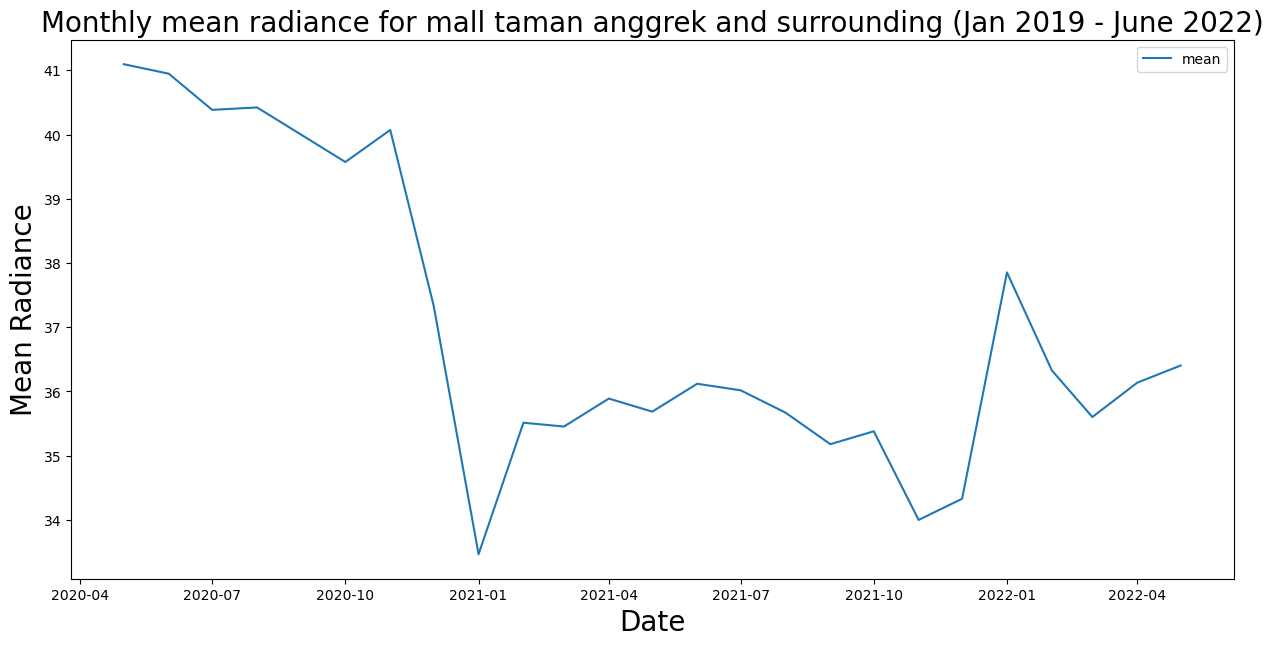

In [21]:
fix, ax  = plt.subplots(figsize=(15, 7))
sns.lineplot(data = anggrek_df.rolling(12).mean(), ax=ax)
ax.set_ylabel('Mean Radiance', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('Monthly mean radiance for mall taman anggrek and surrounding (Jan 2019 - June 2022)', fontsize=20)

In [22]:
anggrek_df.idxmax()

mean   2022-04-01
dtype: datetime64[ns]

## Extract radiance for histogram

In [23]:
viirsDec2019 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2019-12-01','2019-12-31').select('avg_rad').first()

Text(0.5, 1.0, 'Distribution of VIIRS Nov 2019 nighttime lights (Jakarta)')

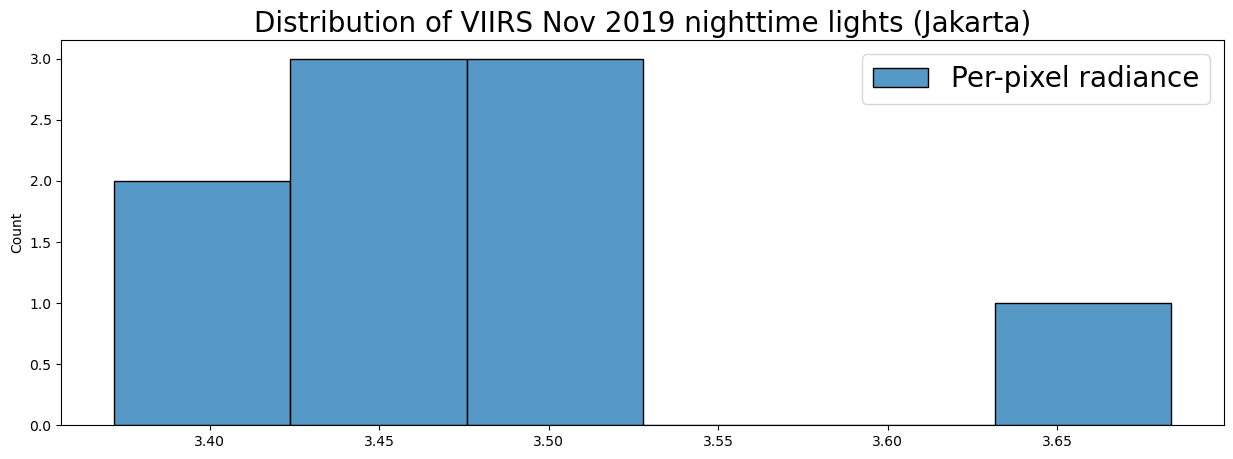

In [24]:
#jakarta
dec19arr = np.array(viirsDec2019.sampleRectangle(poi_anggrek).get('avg_rad').getInfo())
data = np.log(dec19arr).flatten() #flatten array into 1-d

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data, label='Per-pixel radiance', legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS Nov 2019 nighttime lights (Jakarta)', fontsize=20)

## Calculate Rate of Change

In [25]:
viirs_change = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2019-01-01','2022-01-31')
total_month = (2022-2019)*12 + 1

#get first and last image
first_img = viirs_change.sort('system:time_end').first()
last_img = viirs_change.sort('system:time_end', False).first()

#get slope of change (divide over total month)
viirs_slope = (last_img.select('avg_rad').subtract(first_img.select('avg_rad'))).divide(total_month)

In [26]:
map_jakarta = geemap.Map(center=[lat, lon], zoom=8)
viz_params = {'min': -1, 'max': 1, 'palette':['1d4877','1b8a5a','f68838','ee3e32']}

map_jakarta.addLayer(viirs_slope, viz_params, '2019 - 2022 VIIRS-DNB MONTH RATE CHANGE', opacity=0.75)
map_jakarta.addLayerControl()
map_jakarta

#The red/orange indicates increased lights 
#green/blue indicates relative decrease
#zero change is green.

Map(center=[-6.2, 106.8166], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…